## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the Icelandic dataset. B. part is transfer learning with Swiss/GLAMOS train set and Icelandic test set

### Setting Up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.xgb_helpers import *


# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "consensus_ice_thickness",
    "millan_v",
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 49
Number of winter, summer and annual samples: 6546
Number of annual samples: 3185
Number of winter samples: 3361
Number of summer samples: 0


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v',
       'GLACIER', 'POINT_ID'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full_with_hugonnetdhdt.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-08-26 21:13:07,777 - INFO - Loaded preprocessed data.
2025-08-26 21:13:07,779 - INFO - Number of monthly rows: 56209
2025-08-26 21:13:07,786 - INFO - Number of annual samples: 34915
2025-08-26 21:13:07,791 - INFO - Number of winter samples: 21294


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  1989.0 -18.595688  64.790063           0.45       1094.738918   
1  1989.0 -18.595688  64.790063           0.45       1094.738918   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            -45.138918           1049.6  RGI60-06.00234   
1            -45.138918           1049.6  RGI60-06.00234   

                                            POINT_ID  ID  ...   millan_v  \
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   
1  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   

        t2m        tp      slhf      sshf       ssrd      fal        str  \
0 -4.787933  0.003747  198886.0  590722.0  3990646.0  0.84564 -1779436.0   
1 -5.262054  0.003766  306376.0  576896.0   883468.0  0.84690 -1458576.0   

        u10       v10  
0 -0.590102  0.603381  
1  0.129348  2.214950  

[2 rows x 28 columns]

#### A.2. Dataset statistics

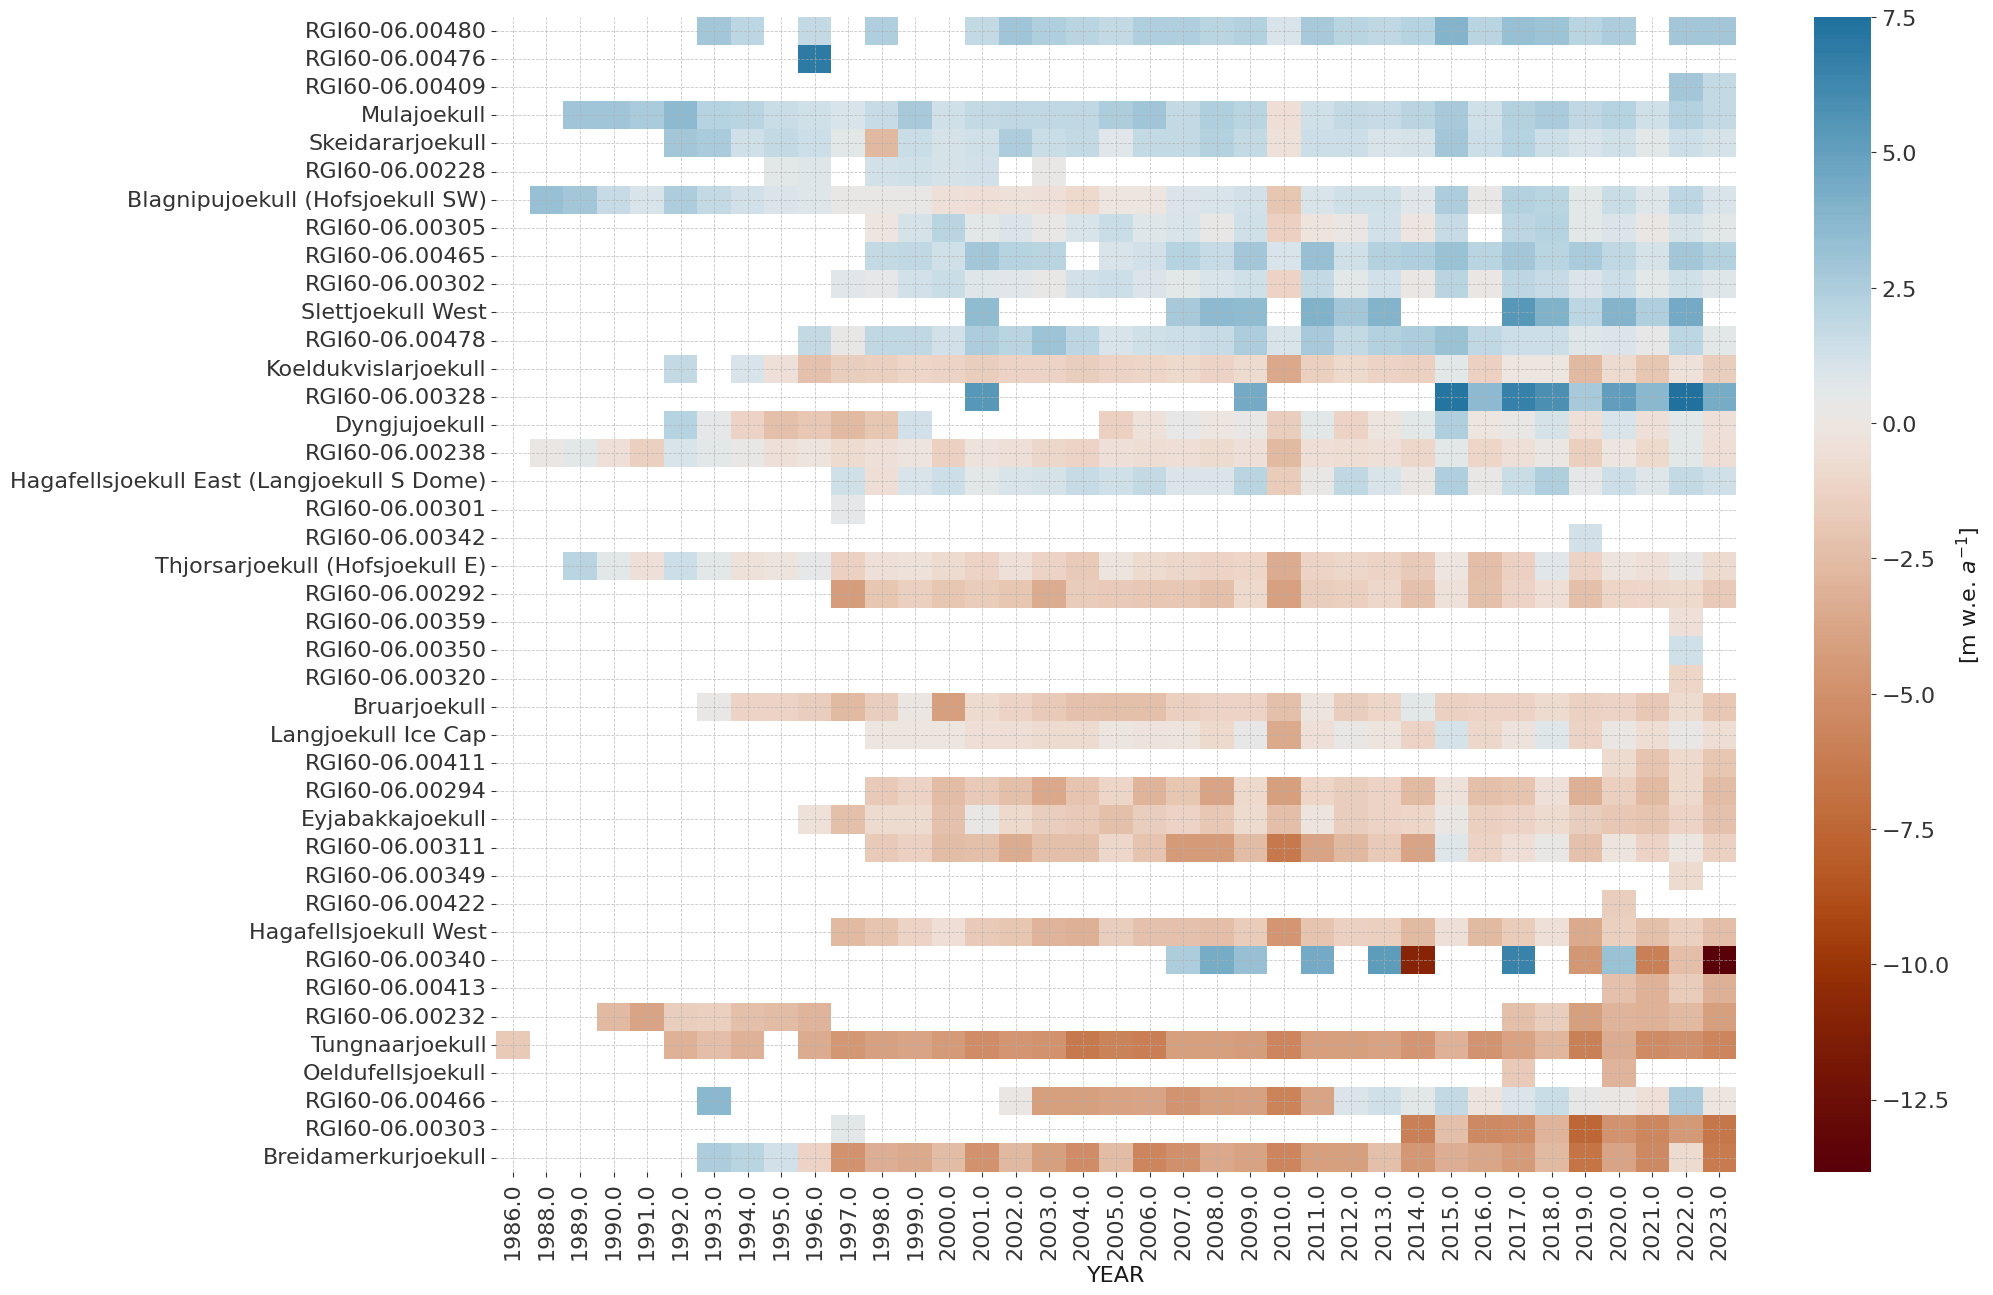

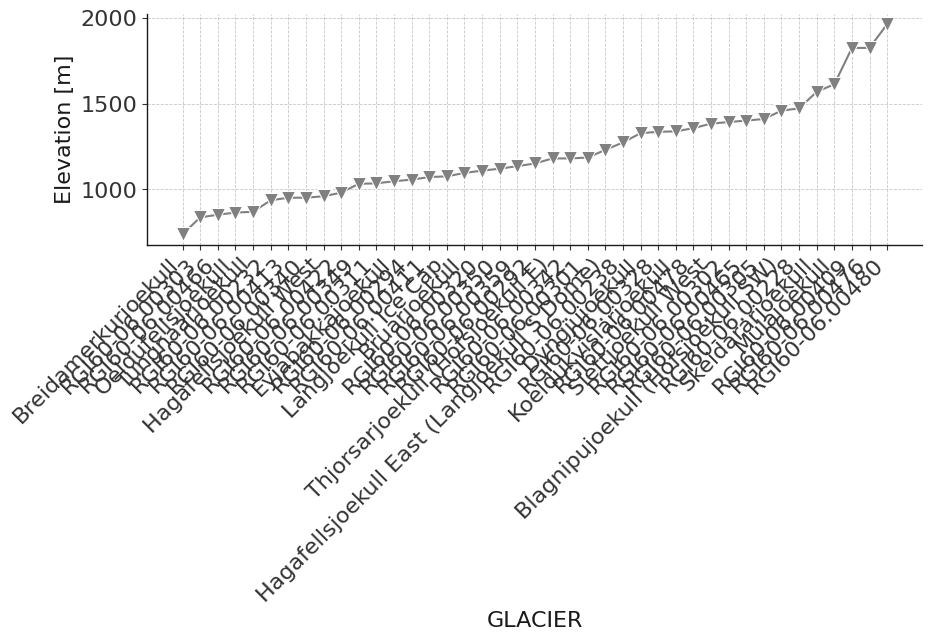

In [5]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

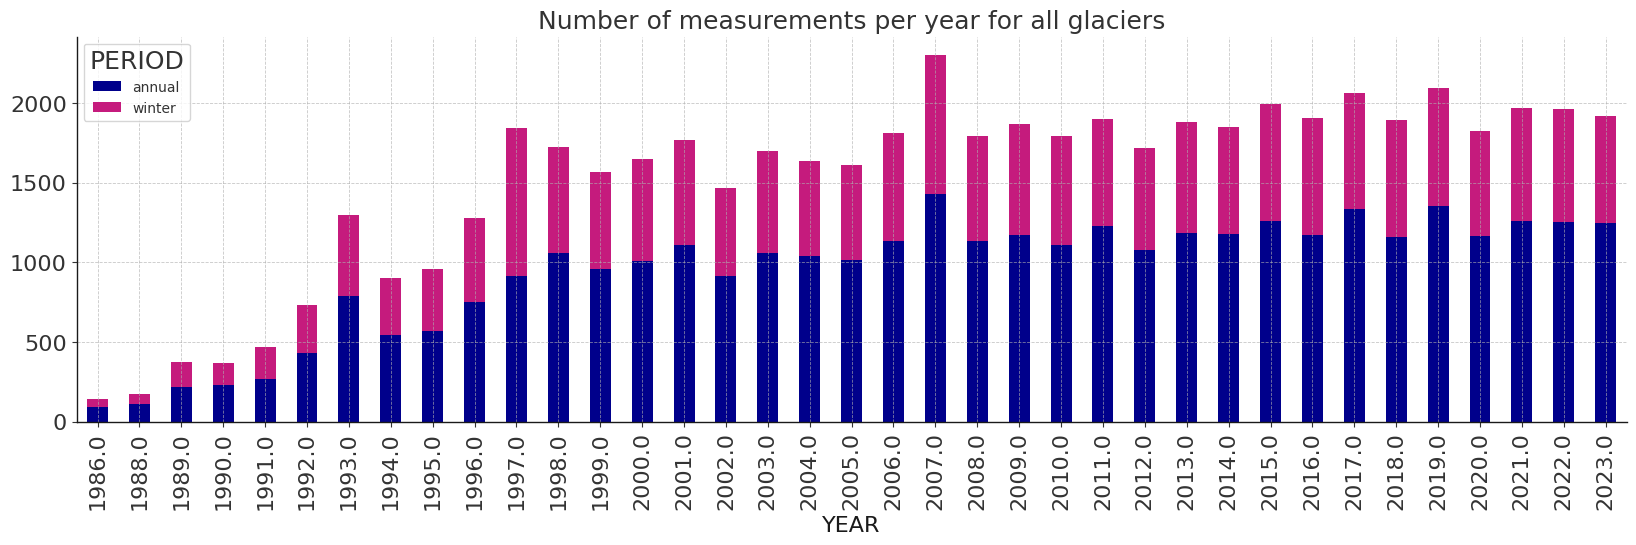

In [6]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

In [ ]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)

In [ ]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Breidamerkurjoekull') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

### A.3. Train-test set split:

###### Either run A.3.1. or A.3.2.

##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

In [18]:
# These are the two icecaps to the west
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

array(['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296'], dtype=object)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import ks_2samp
import random

# CONFIG: features to match distributions on and desired test fraction
features = ['ELEVATION_DIFFERENCE', 't2m', 'ssrd', 'POINT_LAT', 'POINT_LON']   # extend if needed
test_frac = 0.15
K = 4   # number of strata/clusters
seed = cfg.seed

# 1) glacier-level summaries
df = dataloader_gl.data.copy()
gl_stats = df.groupby('GLACIER')[features].agg(['mean','std','count'])
# flatten columns
gl_stats.columns = ['_'.join(col).strip() for col in gl_stats.columns.values]
gl_stats = gl_stats.reset_index()

# use means (and optionally std) to form clustering features
cluster_cols = [c for c in gl_stats.columns if c.endswith('_mean')]
X = gl_stats[cluster_cols].fillna(0).values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# 2) KMeans strata
kmeans = KMeans(n_clusters=K, random_state=seed, n_init=10)
gl_stats['stratum'] = kmeans.fit_predict(Xs)

# 3) stratified sampling of glaciers to get approx test_frac rows
test_glaciers = []
random.seed(seed)
for s, gdf in gl_stats.groupby('stratum'):
    glaciers_in_stratum = list(gdf['GLACIER'].values)
    # choose by groups (glaciers) but try to maintain approximate row fraction:
    # compute number of rows available per glacier then pick until reaching fraction
    rows = df[df.GLACIER.isin(glaciers_in_stratum)].groupby('GLACIER').size().to_dict()
    total_rows = sum(rows.values())
    target_rows = int(total_rows * test_frac)
    # greedy random pick until reach target_rows
    gls = glaciers_in_stratum.copy()
    random.shuffle(gls)
    picked = []
    acc = 0
    for g in gls:
        if acc >= target_rows:
            break
        picked.append(g)
        acc += rows[g]
    test_glaciers.extend(picked)

# Ensure uniqueness and no overlap
test_glaciers = list(dict.fromkeys(test_glaciers))
existing_glaciers = set(df.GLACIER.unique())
test_glaciers = [g for g in test_glaciers if g in existing_glaciers]

train_glaciers = [g for g in existing_glaciers if g not in test_glaciers]

data_test = df[df.GLACIER.isin(test_glaciers)].copy()
data_train = df[df.GLACIER.isin(train_glaciers)].copy()

print("Train rows:", len(data_train), "Test rows:", len(data_test),
      "Ratio train/test rows ≈", round(len(data_train)/max(1,len(data_test)),2))
print("Train glaciers:", len(train_glaciers), "Test glaciers:", len(test_glaciers))

# 4) Diagnostics: KS test for each feature
print("\nKS p-values (train vs test) for key features:")
for f in features:
    p = ks_2samp(data_train[f].dropna(), data_test[f].dropna()).pvalue
    print(f, "KS p:", p, "train mean/std:", data_train[f].mean(), data_train[f].std(),
          "test mean/std:", data_test[f].mean(), data_test[f].std())

display(test_glaciers)

Train rows: 43629 Test rows: 12580 Ratio train/test rows ≈ 3.47
Train glaciers: 34 Test glaciers: 13

KS p-values (train vs test) for key features:
ELEVATION_DIFFERENCE KS p: 4.652773523645322e-180 train mean/std: 64.87235949502555 180.53436641660196 test mean/std: 76.16487146868431 176.64923856711948
t2m KS p: 3.792681468068494e-24 train mean/std: -4.401660375606678 4.618733356827206 test mean/std: -4.882045434123951 4.592985737023443
ssrd KS p: 0.009015070405853707 train mean/std: 7487157.266869513 7290773.599431248 test mean/std: 7526344.8575417325 7351878.467764512
POINT_LAT KS p: 0.0 train mean/std: 64.62202676091017 0.24195819522642653 test mean/std: 64.60983745693792 0.2499916792898949
POINT_LON KS p: 0.0 train mean/std: -18.107720279885736 1.6029625227701234 test mean/std: -18.097037189988054 1.1548348905132042


['RGI60-06.00311',
 'RGI60-06.00305',
 'Thjorsarjoekull (Hofsjoekull E)',
 'RGI60-06.00445',
 'RGI60-06.00474',
 'RGI60-06.00425',
 'RGI60-06.00480',
 'Dyngjujoekull',
 'RGI60-06.00478',
 'Koeldukvislarjoekull',
 'Oeldufellsjoekull',
 'RGI60-06.00350',
 'RGI60-06.00340']

In [7]:
"""
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']
"""

# about 75%
test_glaciers = ['RGI60-06.00311',
 'RGI60-06.00305',
 'Thjorsarjoekull (Hofsjoekull E)',
 'RGI60-06.00445',
 'RGI60-06.00474',
 'RGI60-06.00425',
 'RGI60-06.00480',
 'Dyngjujoekull',
 'RGI60-06.00478',
 'Koeldukvislarjoekull',
 'Oeldufellsjoekull',
 'RGI60-06.00350',
 'RGI60-06.00340']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 12580
Size of train data: 43629
Percentage of test size: 28.83%
Train glaciers: (34) ['Breidamerkurjoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Hagafellsjoekull West' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Skeidararjoekull' 'Slettjoekull West'
 'RGI60-06.00466' 'RGI60-06.00411' 'RGI60-06.00302' 'RGI60-06.00359'
 'Bruarjoekull' 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238'
 'RGI60-06.00320' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00342' 'RGI60-06.00465' 'RGI60-06.00294' 'RGI60-06.00292'
 'RGI60-06.00232' 'Mulajoekull' 'RGI60-06.00301' 'RGI60-06.00413'
 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349'
 'RGI60-06.00422' 'RGI60-06.00306' 'RGI60-06.00479' 'RGI60-06.00296']
Test glaciers: (13) ['Thjorsarjoekull (Hofsjoekull E)' 'Dyngjujoekull' 'Koeldukvislarjoekull'
 'Oeldufellsjoekull' 'RGI60-06.00340' 'RGI60-06.00480' 'RGI60-06.00478'
 'RGI60-06.00311' 'RGI60-06.00350' 'RGI60-06.00305' 'RGI60-06.00425'
 'RGI6

In [36]:

import folium
from folium.plugins import MarkerCluster


from IPython.display import IFrame, display

# derive test_glaciers if not in scope
if 'test_glaciers' not in globals():
    try:
        test_glaciers = list(test_set['df_X']['GLACIER'].unique())
    except Exception:
        raise RuntimeError("test_glaciers not defined and test_set not available. Define test_glaciers first.")

df = dataloader_gl.data.copy()

# representative lat/lon per glacier (mean of available points)
pts = (
    df[df['GLACIER'].isin(test_glaciers)]
    .groupby('GLACIER')[['POINT_LAT', 'POINT_LON']]
    .mean()
    .dropna()
    .reset_index()
)

if pts.empty:
    raise RuntimeError("No POINT_LAT/POINT_LON found for selected test_glaciers.")

# center map on mean location and create marker cluster
center = [pts['POINT_LAT'].mean(), pts['POINT_LON'].mean()]
m = folium.Map(location=center, tiles='CartoDB.Positron', zoom_start=6)
mc = MarkerCluster().add_to(m)

for _, row in pts.iterrows():
    popup_html = f"<b>{row['GLACIER']}</b><br>Lat: {row['POINT_LAT']:.4f}<br>Lon: {row['POINT_LON']:.4f}"
    folium.CircleMarker(
        location=[row['POINT_LAT'], row['POINT_LON']],
        radius=6,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=300)
    ).add_to(mc)

# fit map to points with padding
bounds = [[pts['POINT_LAT'].min(), pts['POINT_LON'].min()], [pts['POINT_LAT'].max(), pts['POINT_LON'].max()]]
m.fit_bounds(bounds, padding=(30, 30))

# save and display
out_html = 'test_glaciers_map.html'
m.save(out_html)
display(IFrame(out_html, width='100%', height=600))

##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)


print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.3. Train-Test set plots

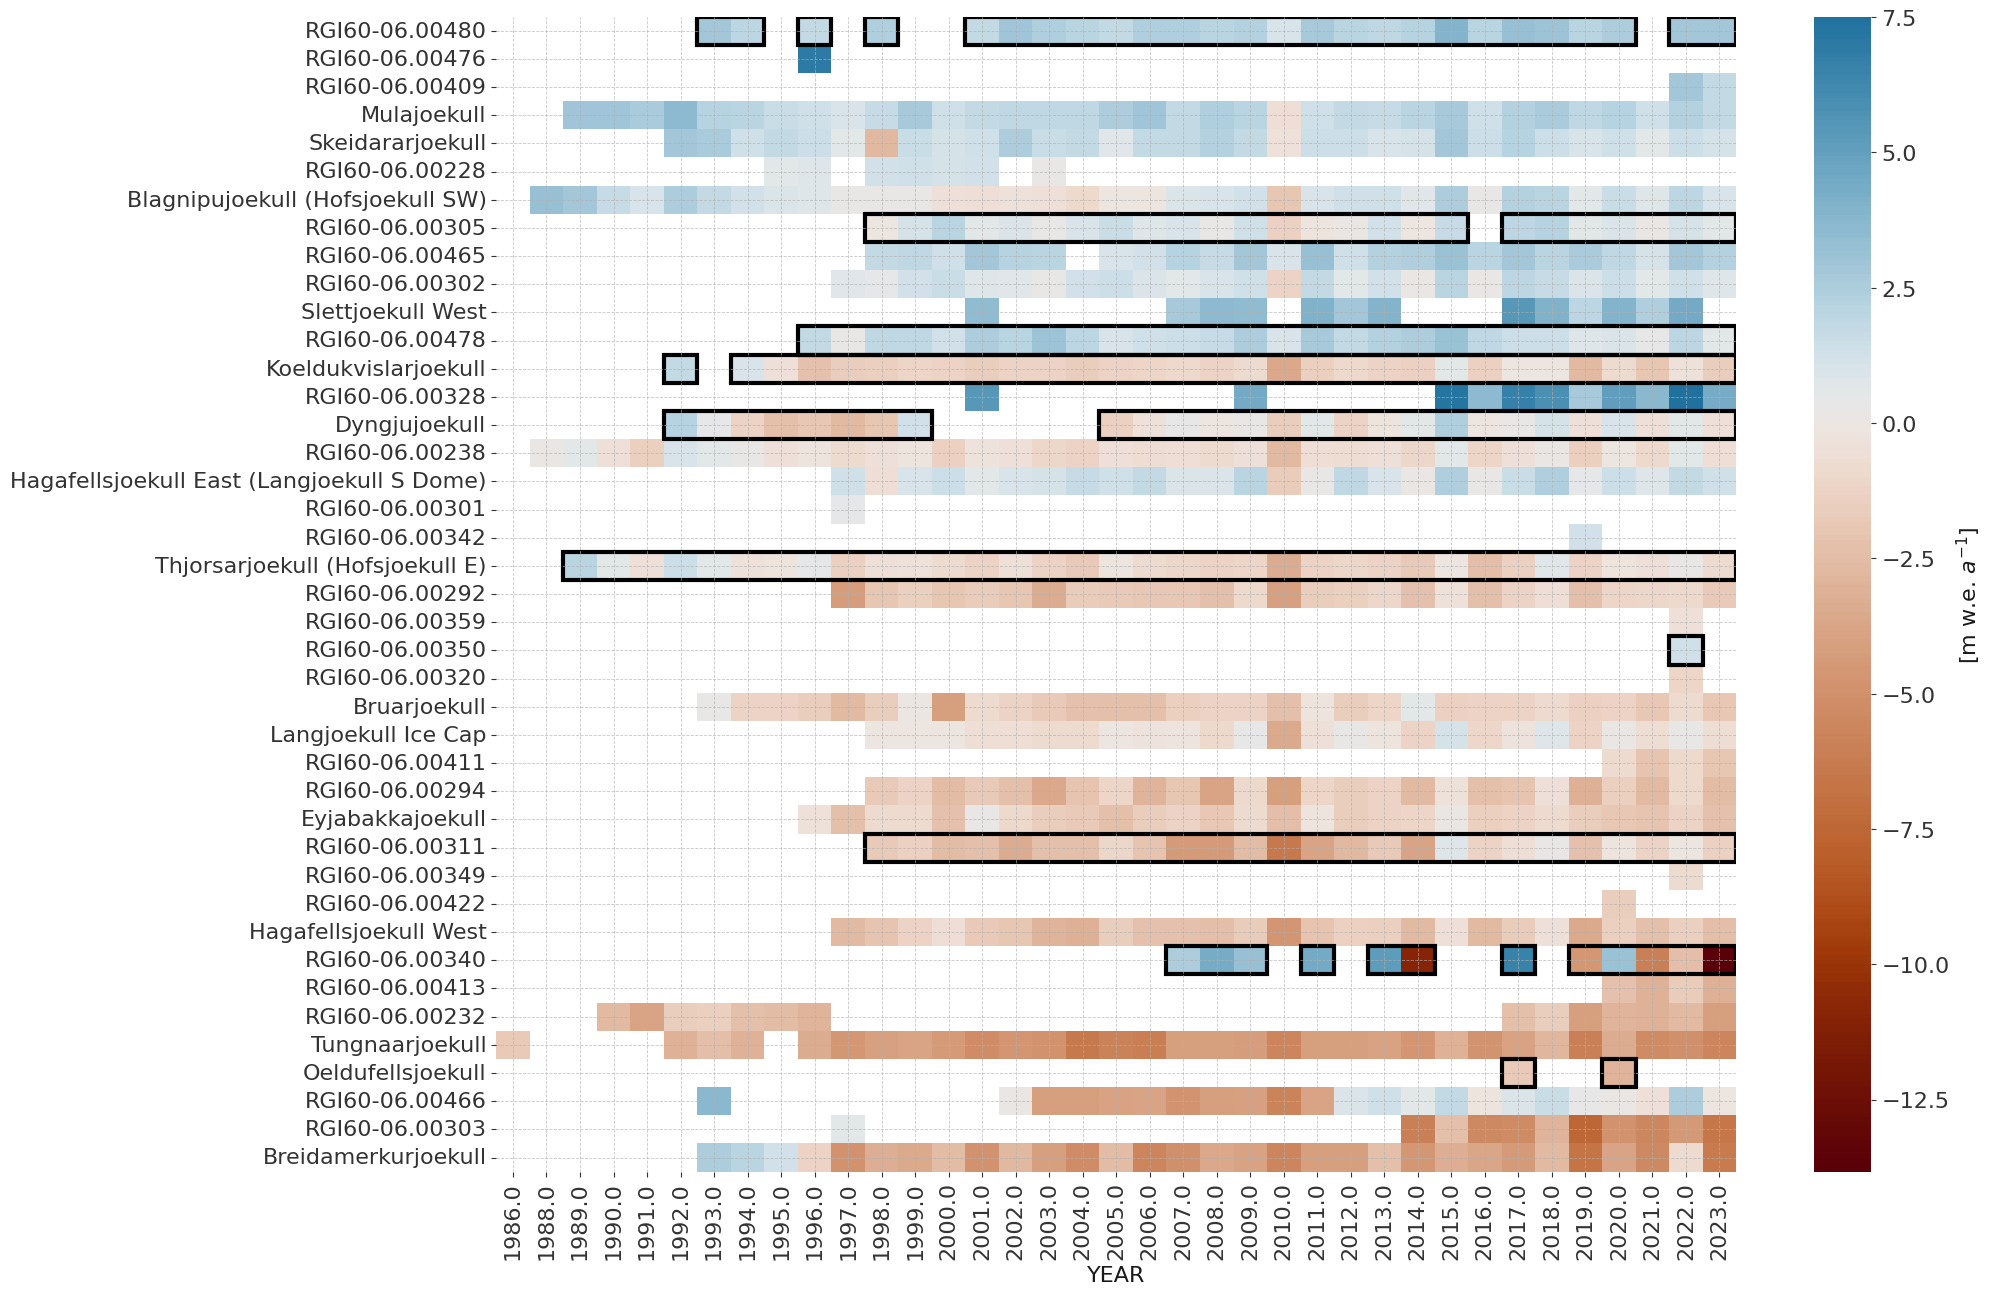

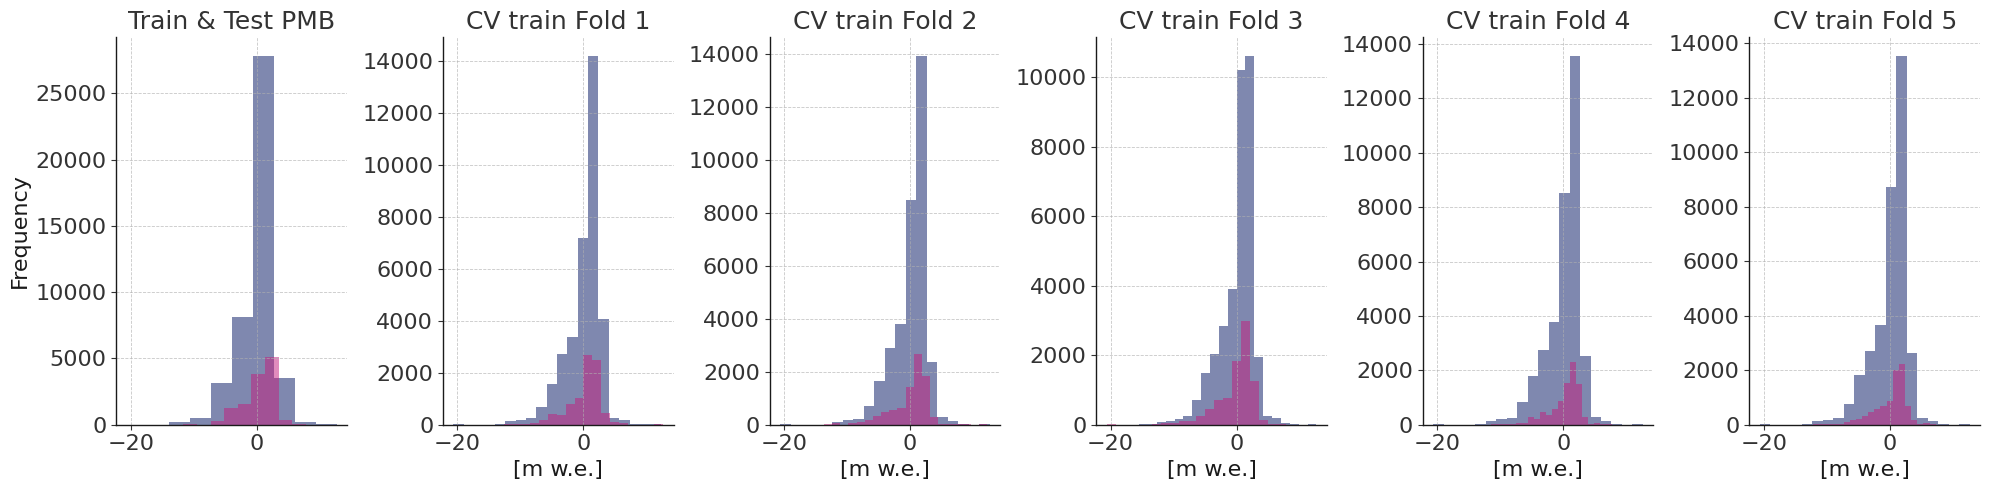

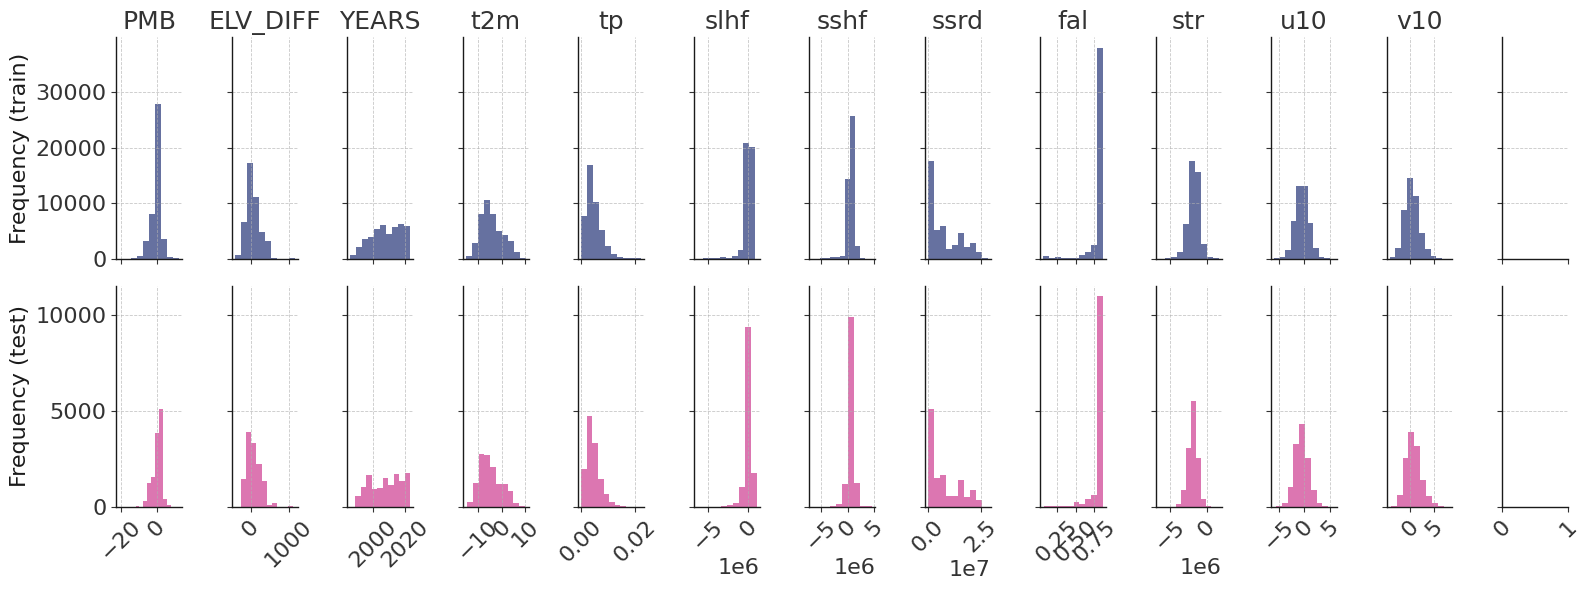

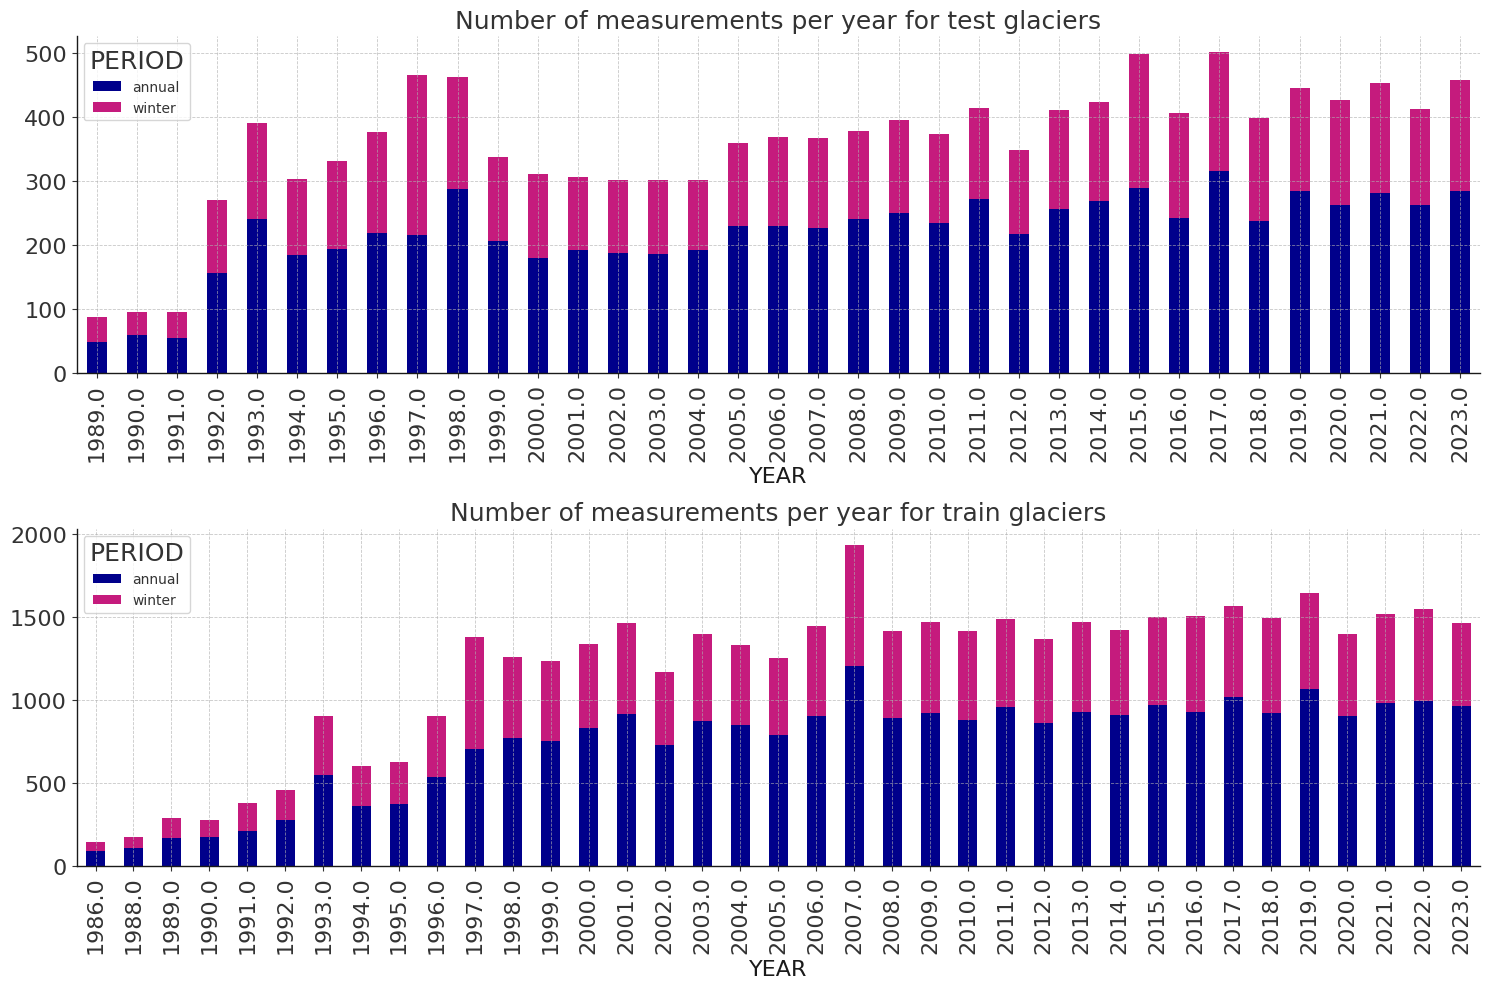

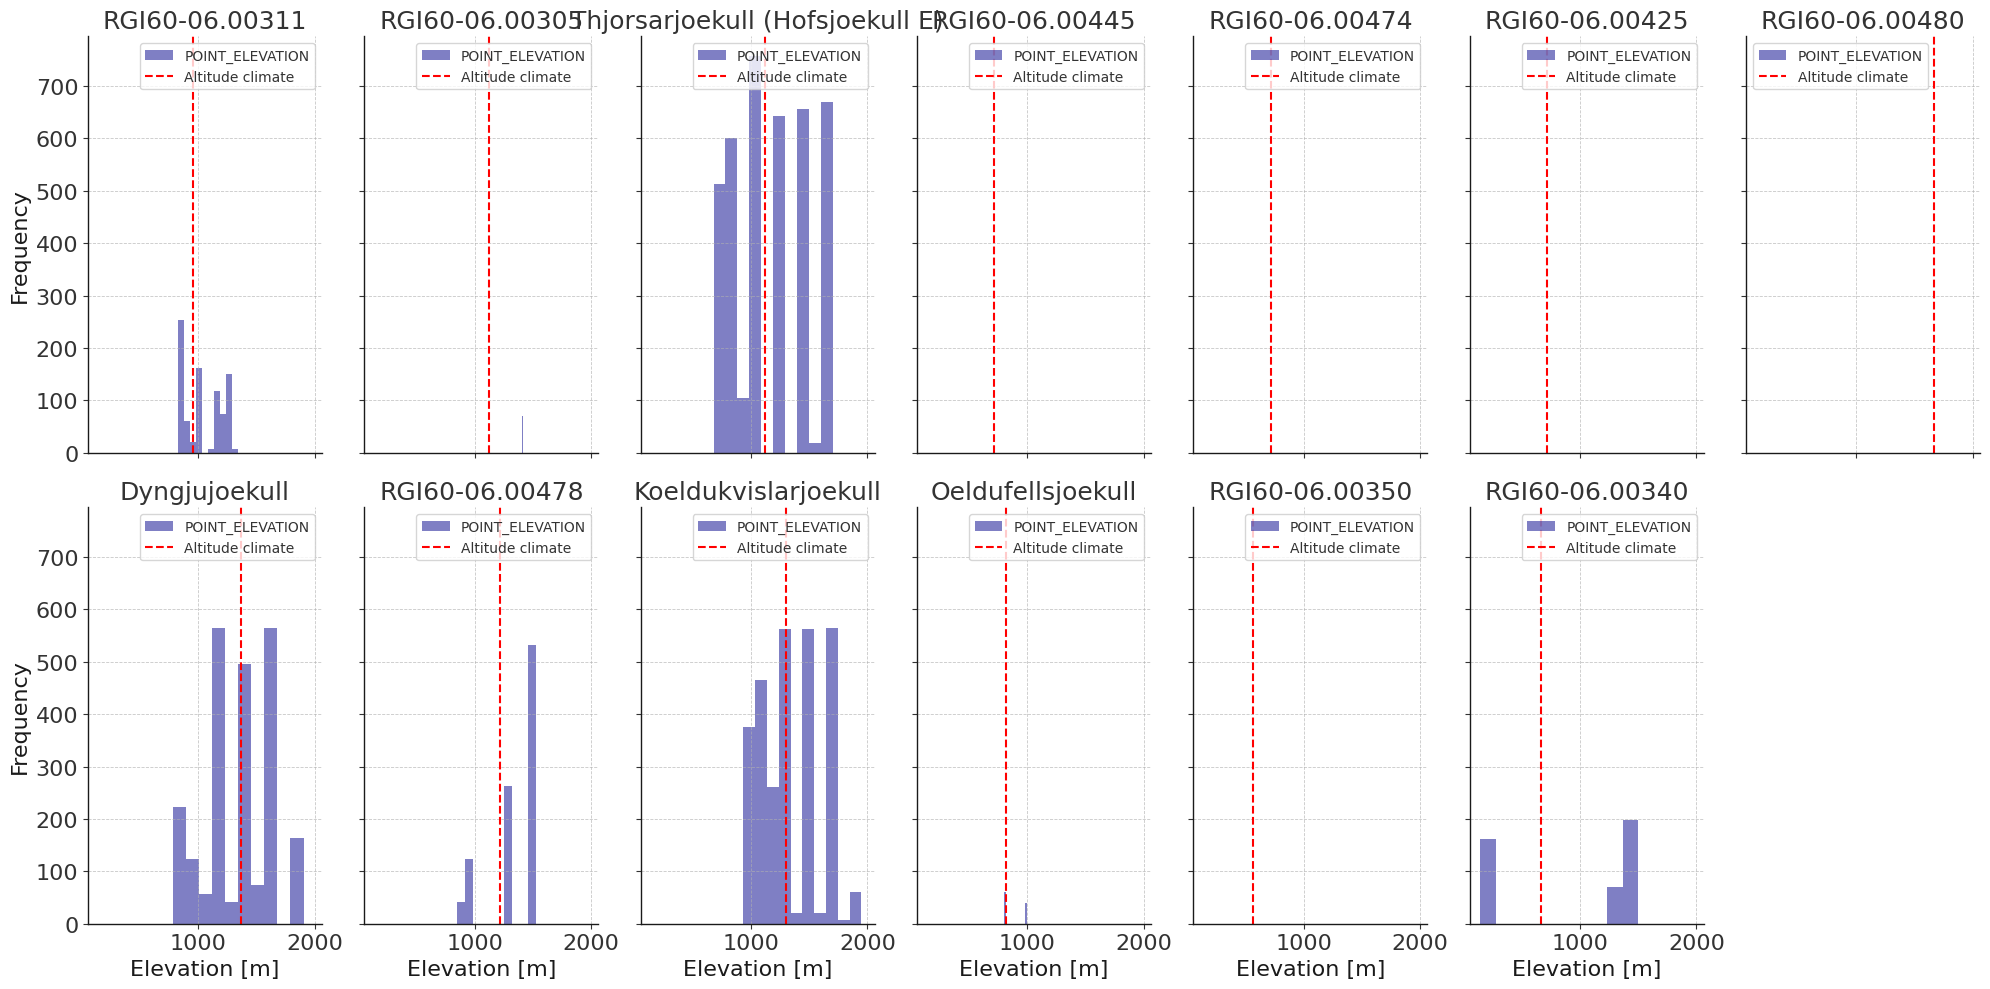

In [8]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### A.4. XGBoost:

In [9]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700, 800],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 12

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "consensus_ice_thickness",
    "millan_v",
]

###### Grid search:

In [12]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Iceland_26_08_75%_regional.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Iceland_26_08_75%_regional_with_hugonnet_dhdt_lr0_01_depth_8_nestimators_700.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (43629, 27)
Shape of testing dataset: (12580, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.4502272201093239
Shape of the test: (12580, 14)
Overall score: 0.9017961013852657
CPU times: user 1.29 s, sys: 30.4 ms, total: 1.32 s
Wall time: 156 ms


learning_rate  max_depth  n_estimators  Validation rmse  Train rmse
Model                                                                     
1               0.01          8           700         0.450227    0.020357
2               0.10          5           800         0.485353    0.006195
3               0.10          7           500         0.491929    0.001239
4               0.10          4           800         0.492309    0.021426
5               0.10          5           400         0.501570    0.018736
6               0.10          7           200         0.505999    0.008881
7               0.10          8           500         0.538091    0.000249
8               0.10          8           400         0.538924    0.000539
9               0.15          4           400         0.572114    0.043049
10              0.01          7           200         0.572683    0.139137

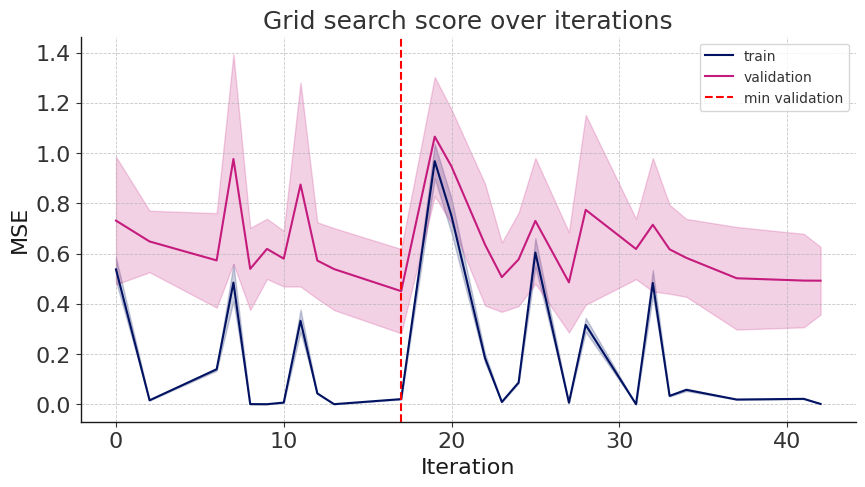

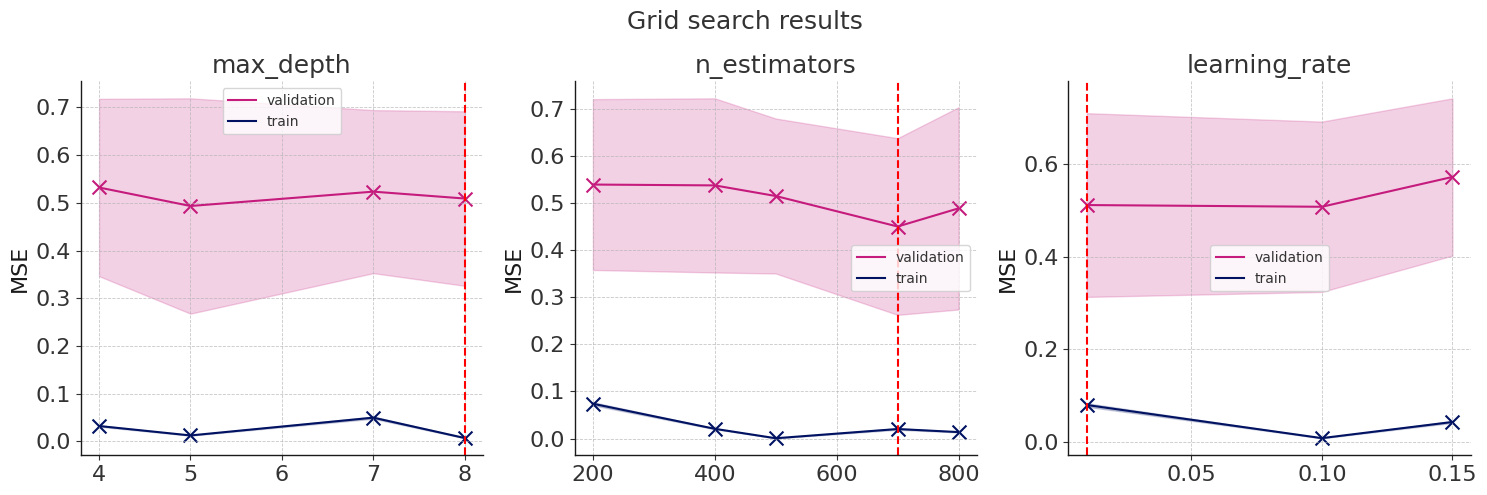

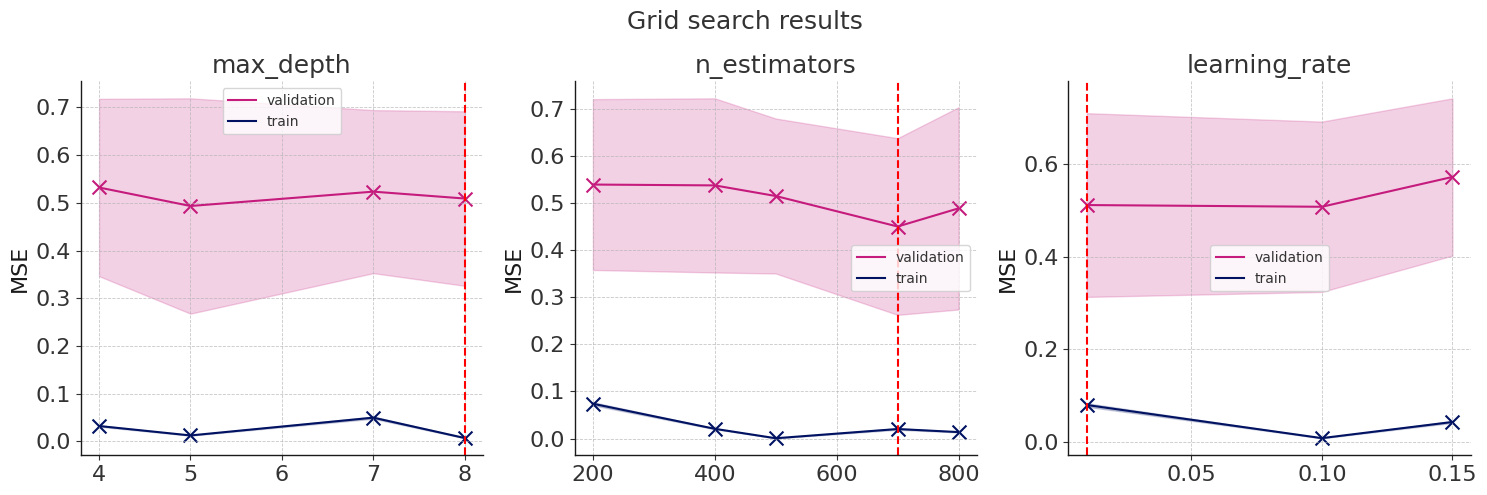

In [13]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

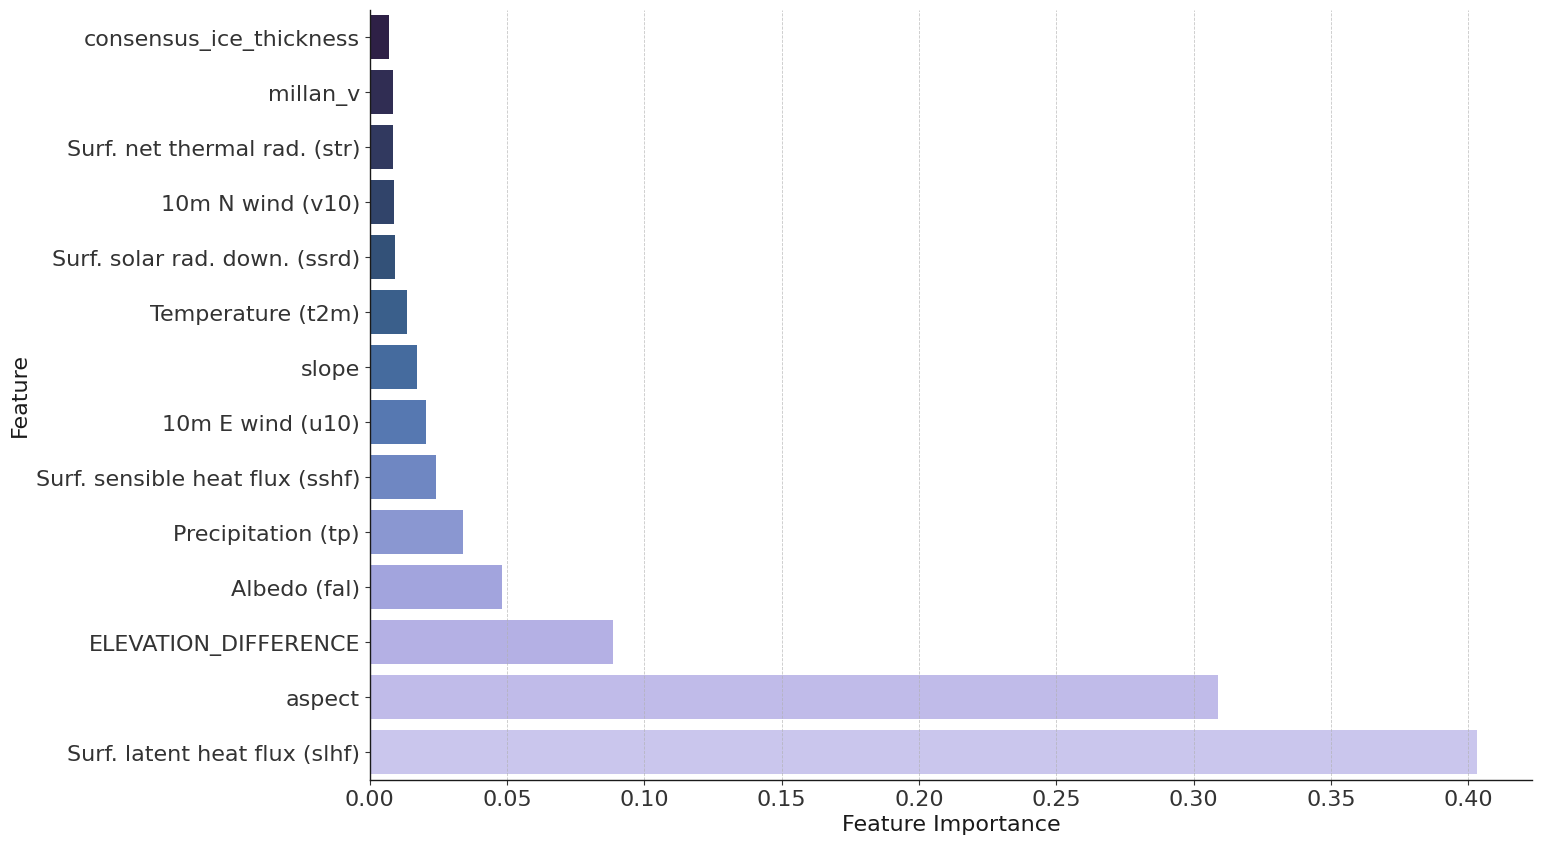

In [14]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

Shape of the test: (12580, 14)


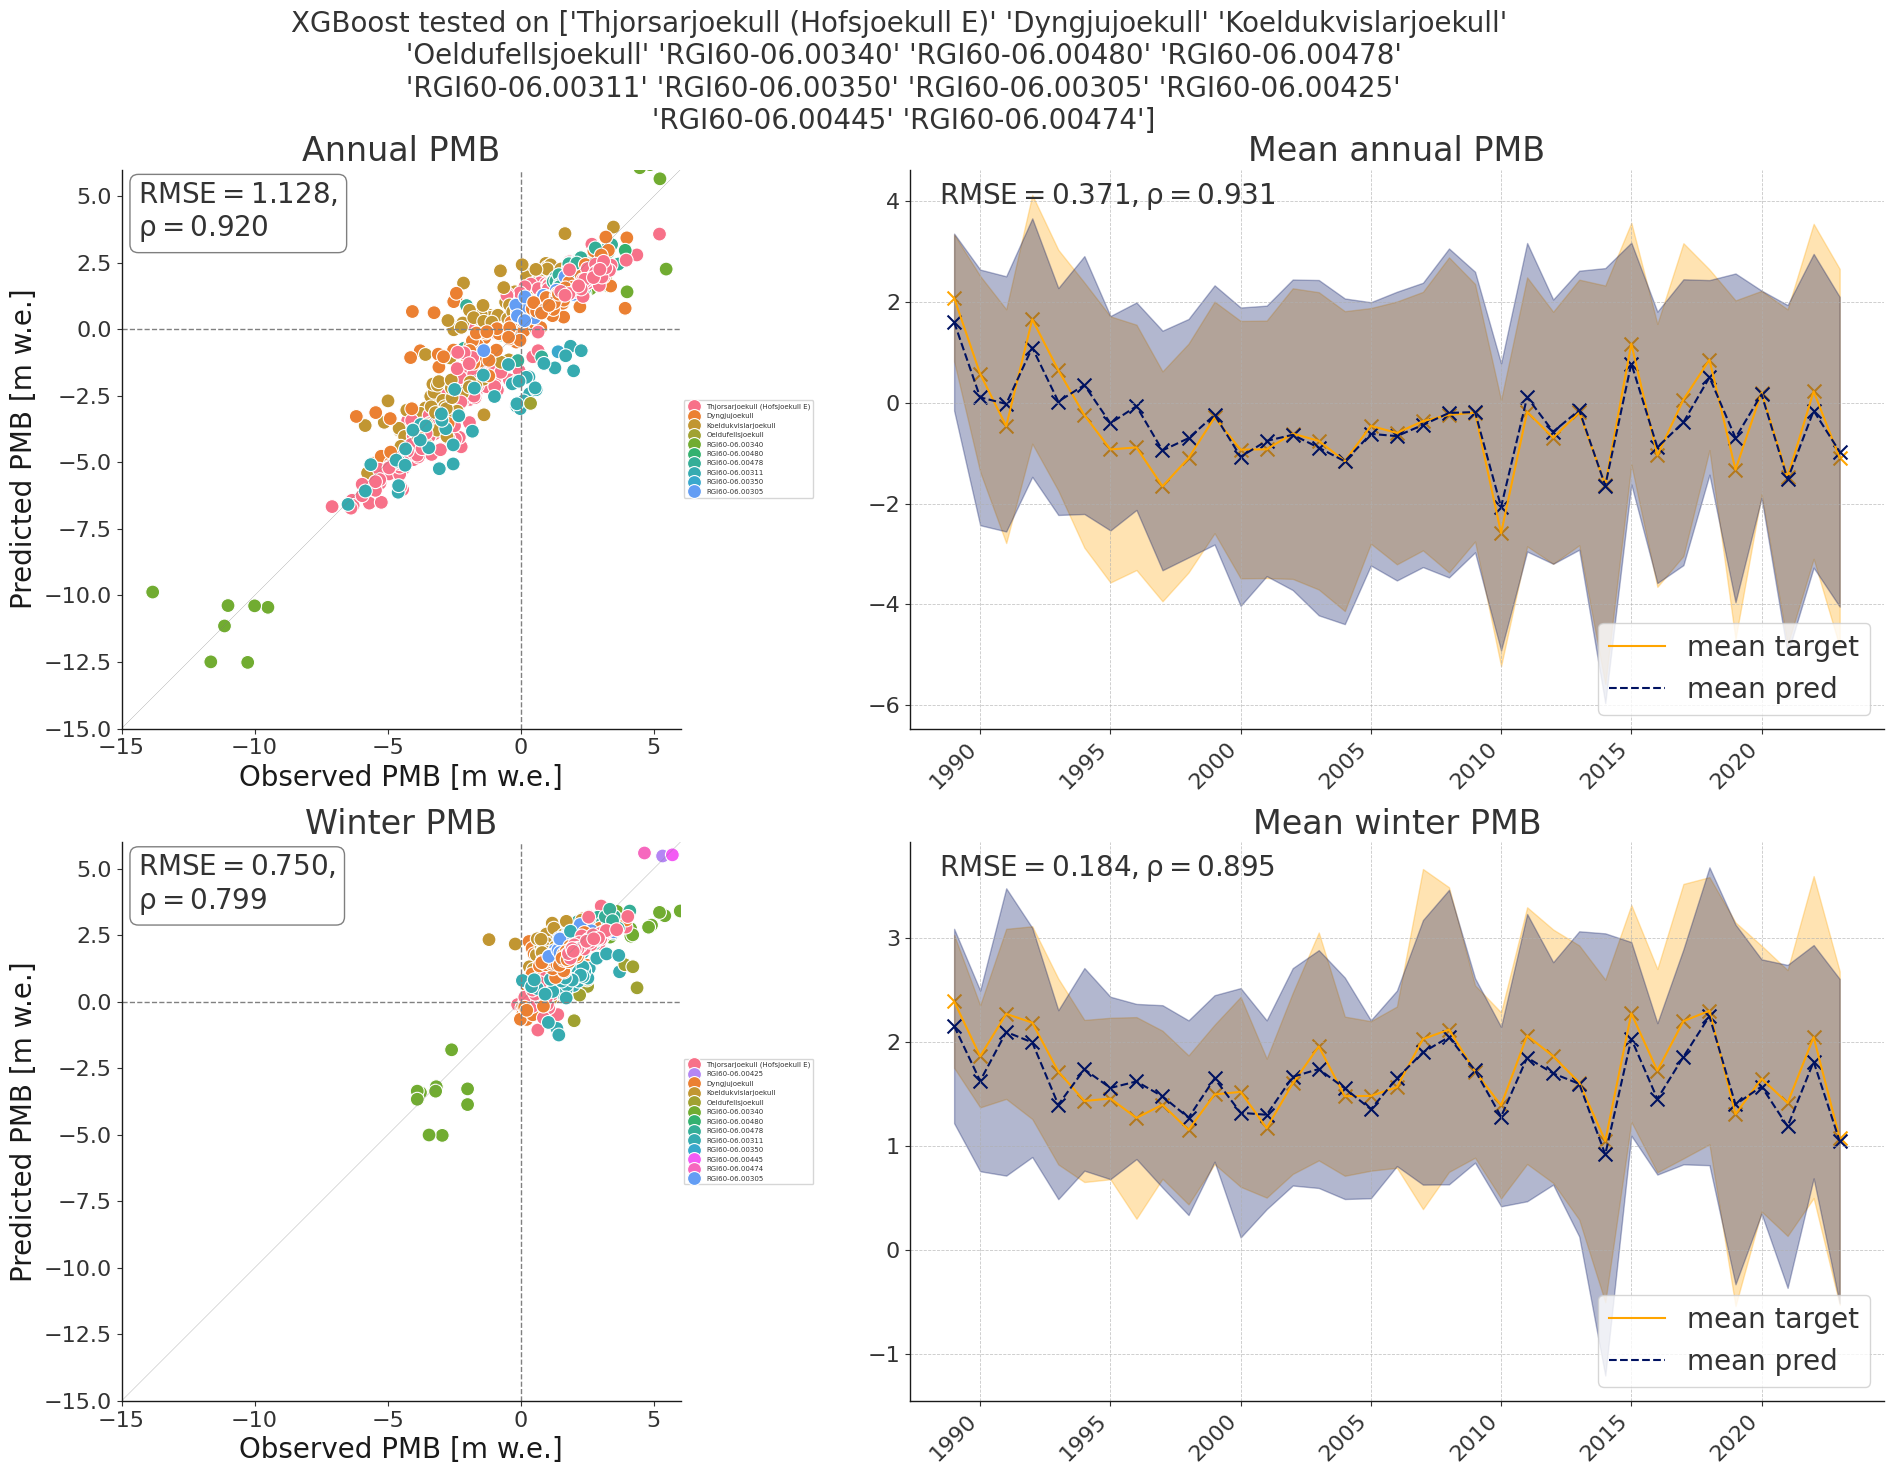

In [15]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=False)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

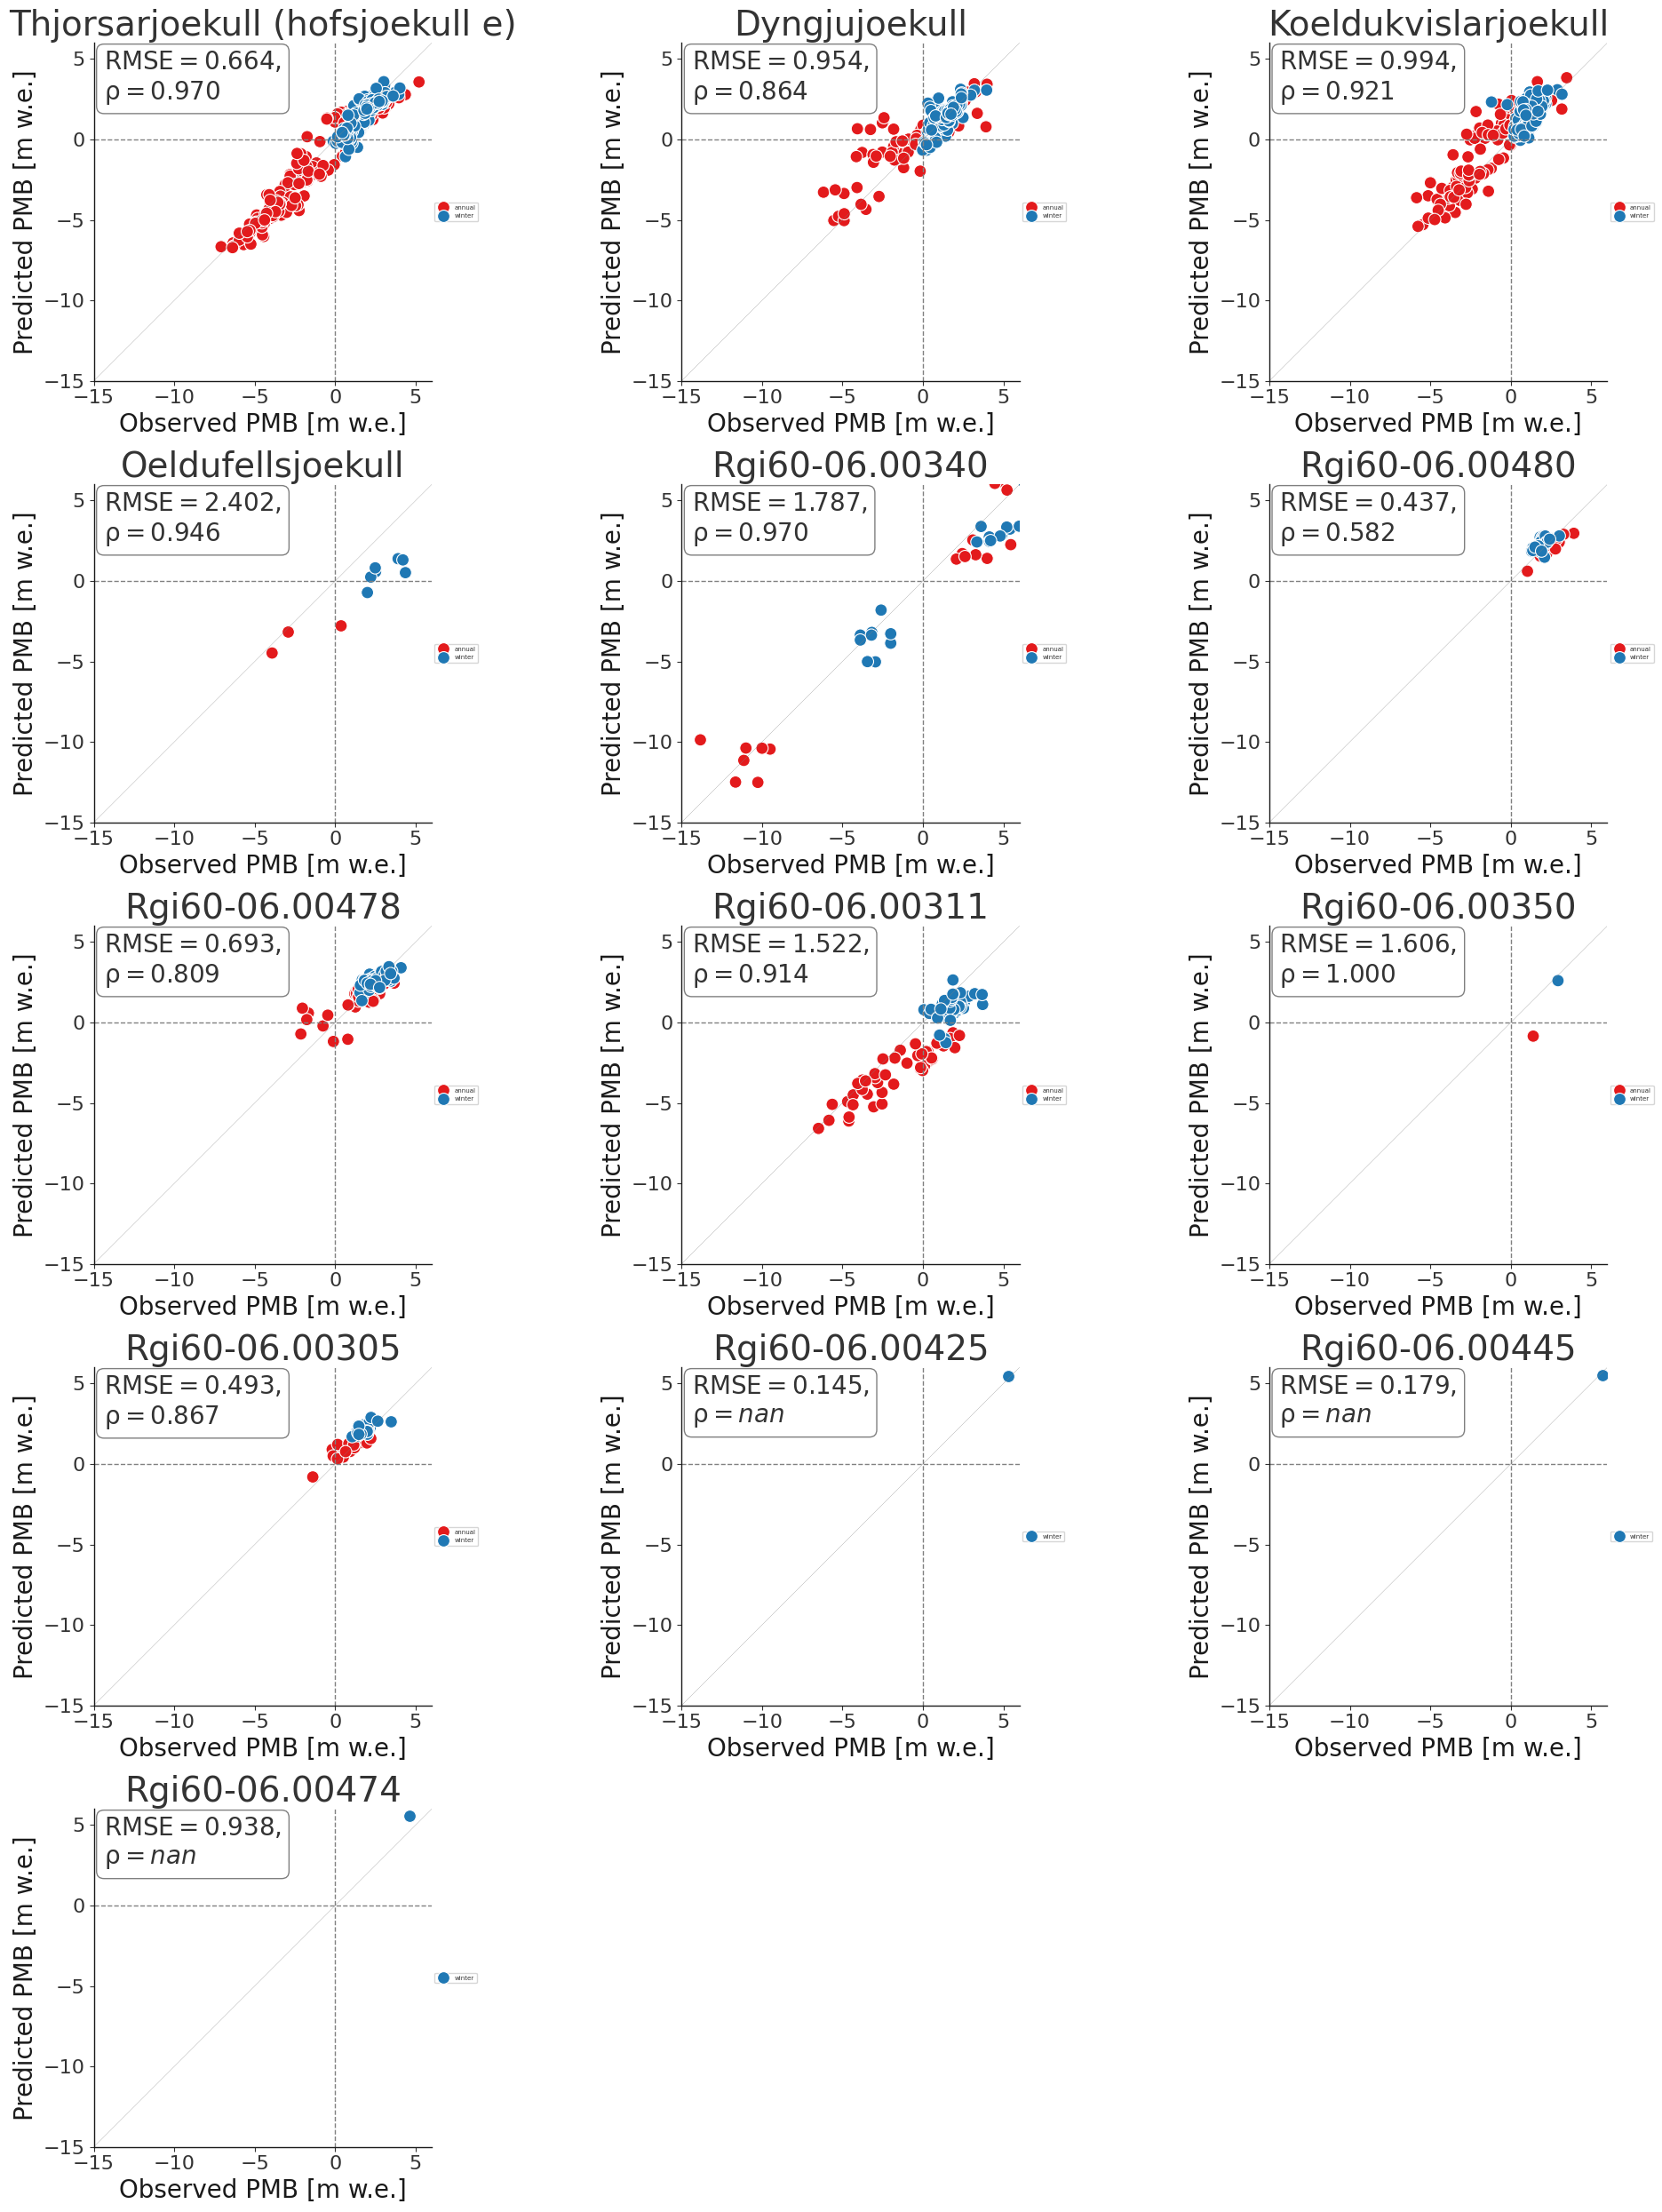

In [16]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

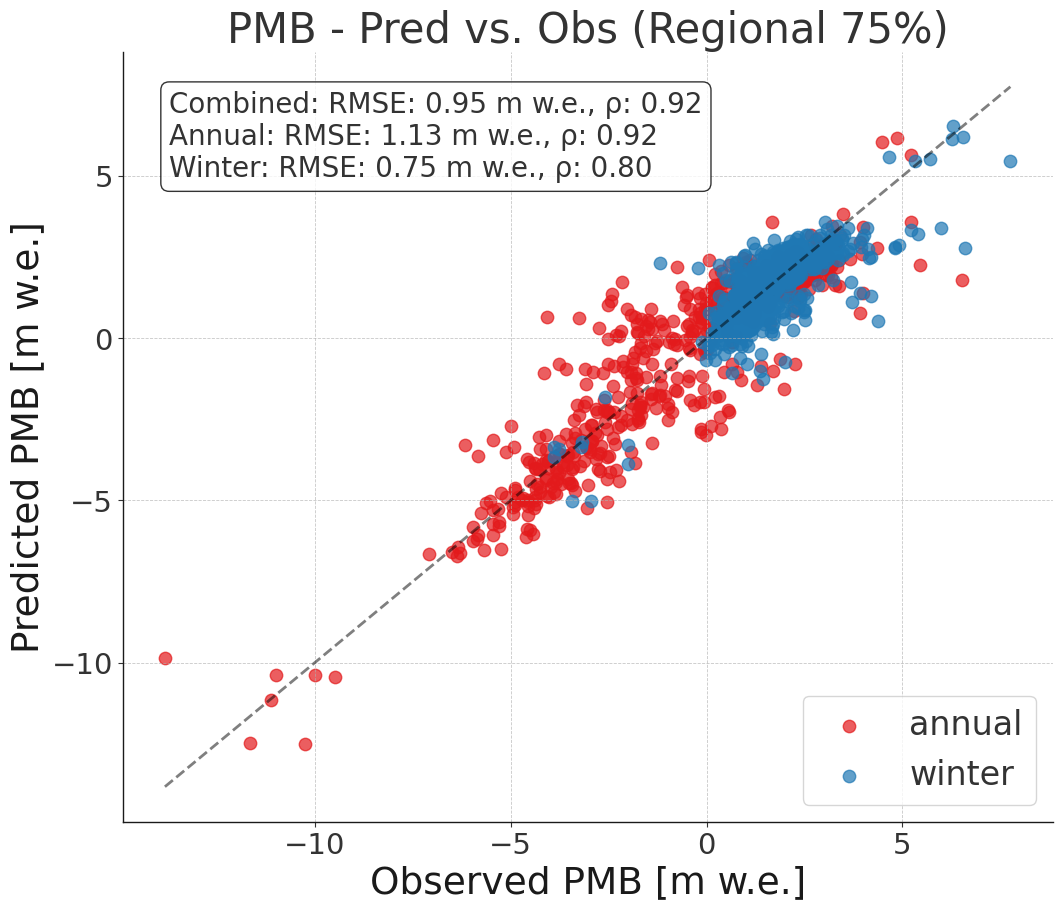

In [18]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Regional 75%', include_summer = False)

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 4)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = ['Hagafellsjoekull West_2017.0_annual_L10']

plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### B.1. Train CH Test ICE

In [ ]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm.csv')

display(data_CH.columns)

display(data_ICE.columns)

data_CH = data_CH.drop(['hugonnet_dhdt', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH.head(2))

display(len(data_ICE_CH['GLACIER'].unique()))

###### Add ERA5Land data to the combined CH_ICE stakes

In [ ]:
data_CH_ICE_test = data_ICE_CH.copy()

display(data_CH_ICE_test.shape)
display(data_CH_ICE_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE.head(2))

###### Test and Train set

In [ ]:
test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = list(data_CH['GLACIER'].unique())

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### B.2. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### B.4. XGBoost

In [ ]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    #"hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

#### Grid Search

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_train_ICE_test_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_train_ICE_test_11_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)

PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on Iceland glaciers trained on CH', fontsize=20)
plt.tight_layout()

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train ICE Test', include_summer = False)

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None)
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 5)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = ['Bruarjoekull_1999.0_annual_Bru']

plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly_CH_ICE,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### Predictions of custom parameters:

Shape of training dataset: (43508, 27)
Shape of testing dataset: (12701, 27)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 20, 'n_jobs': 12, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}
Shape of the test: (12701, 14)
Overall score: 2.5696663766951064


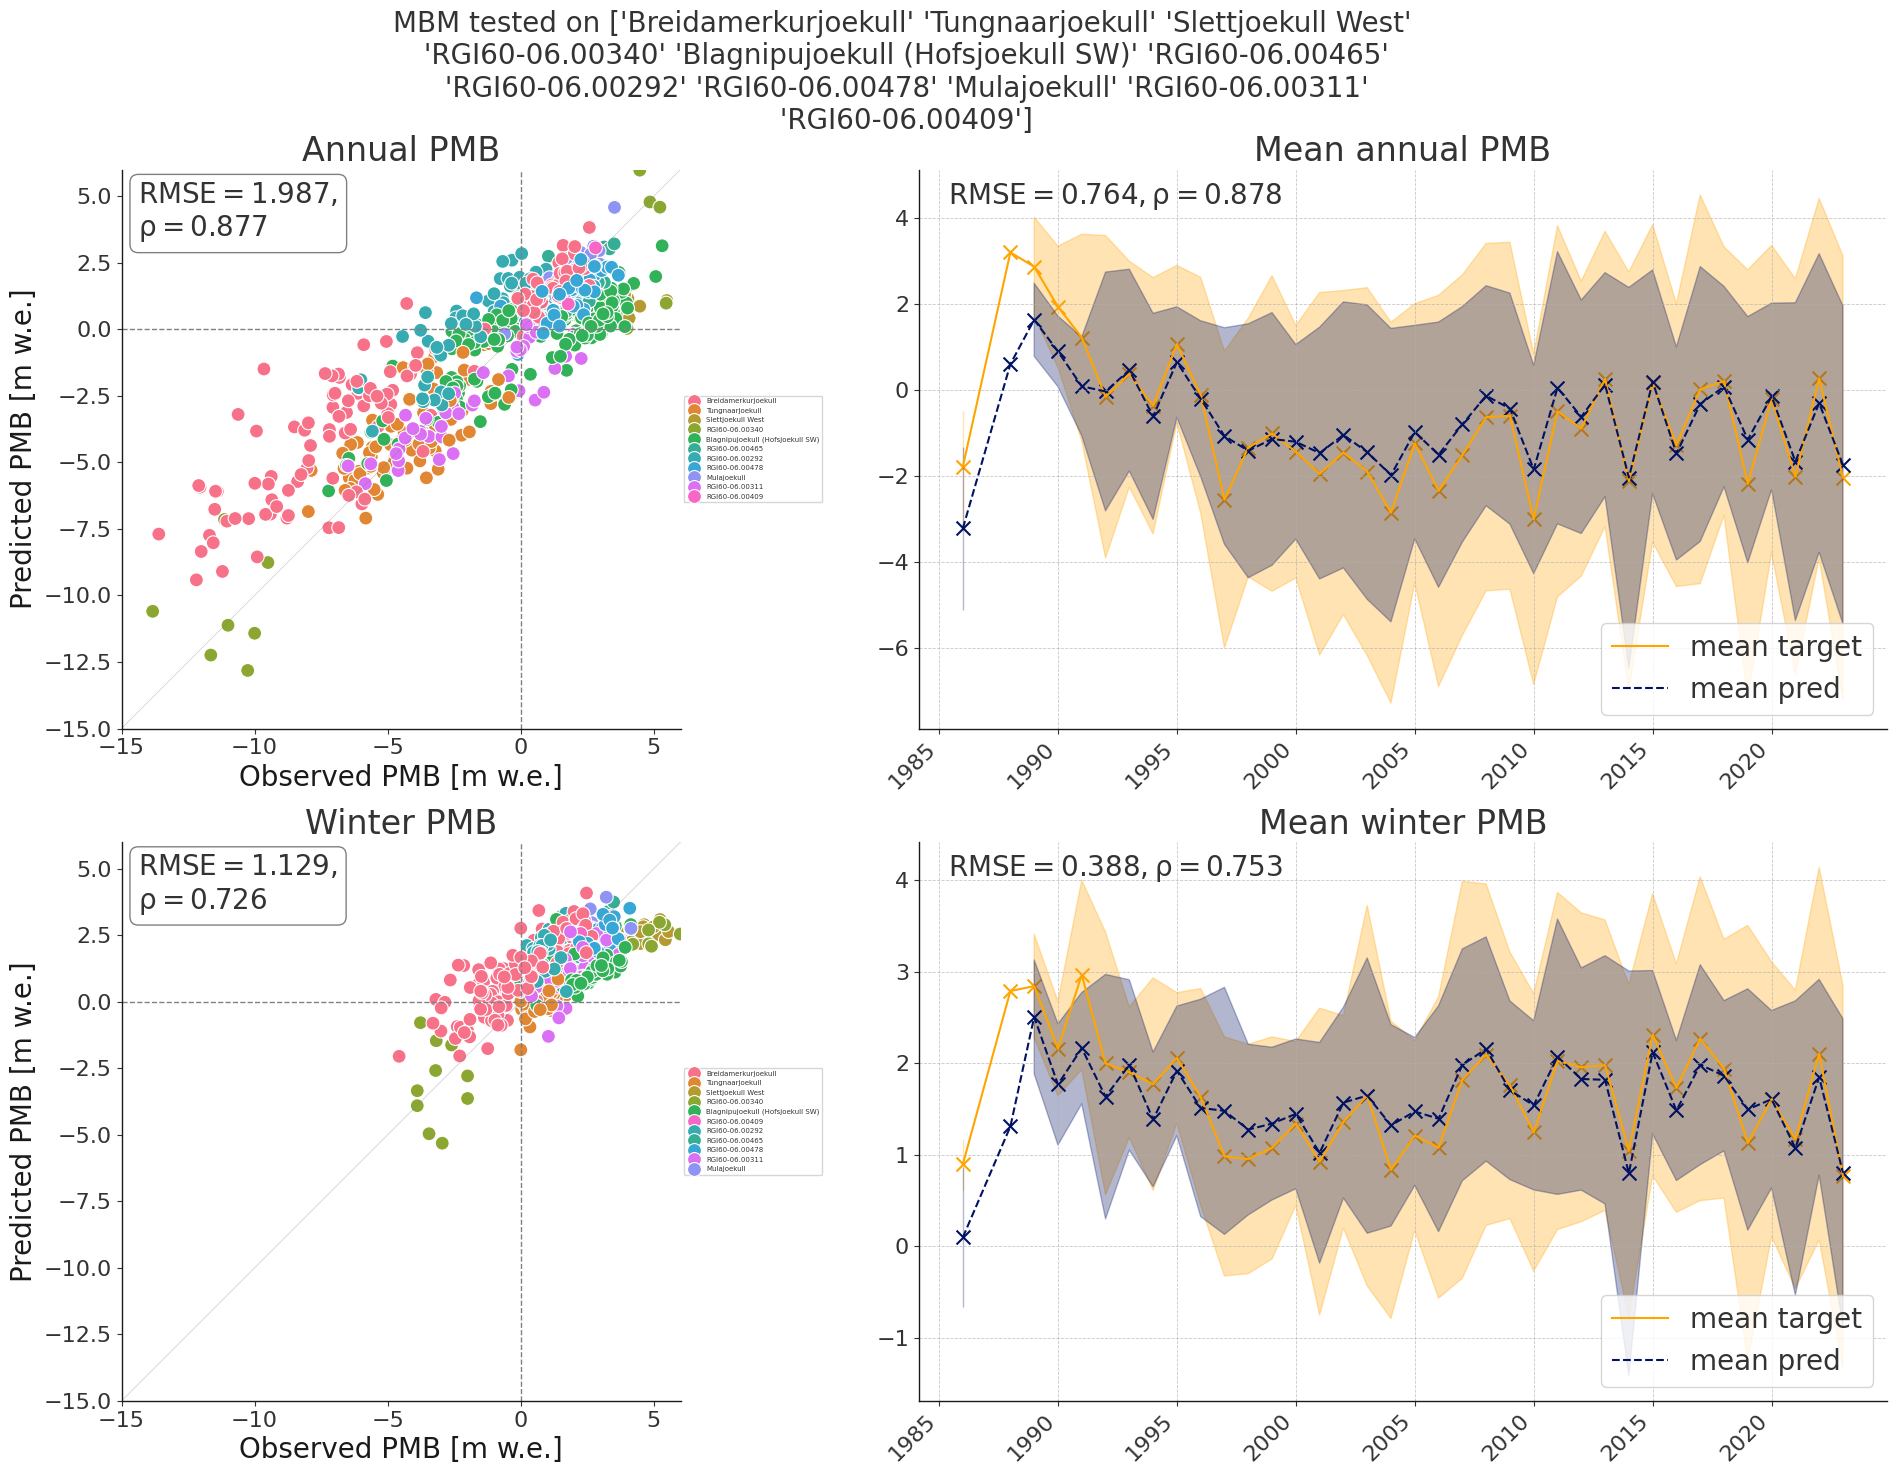

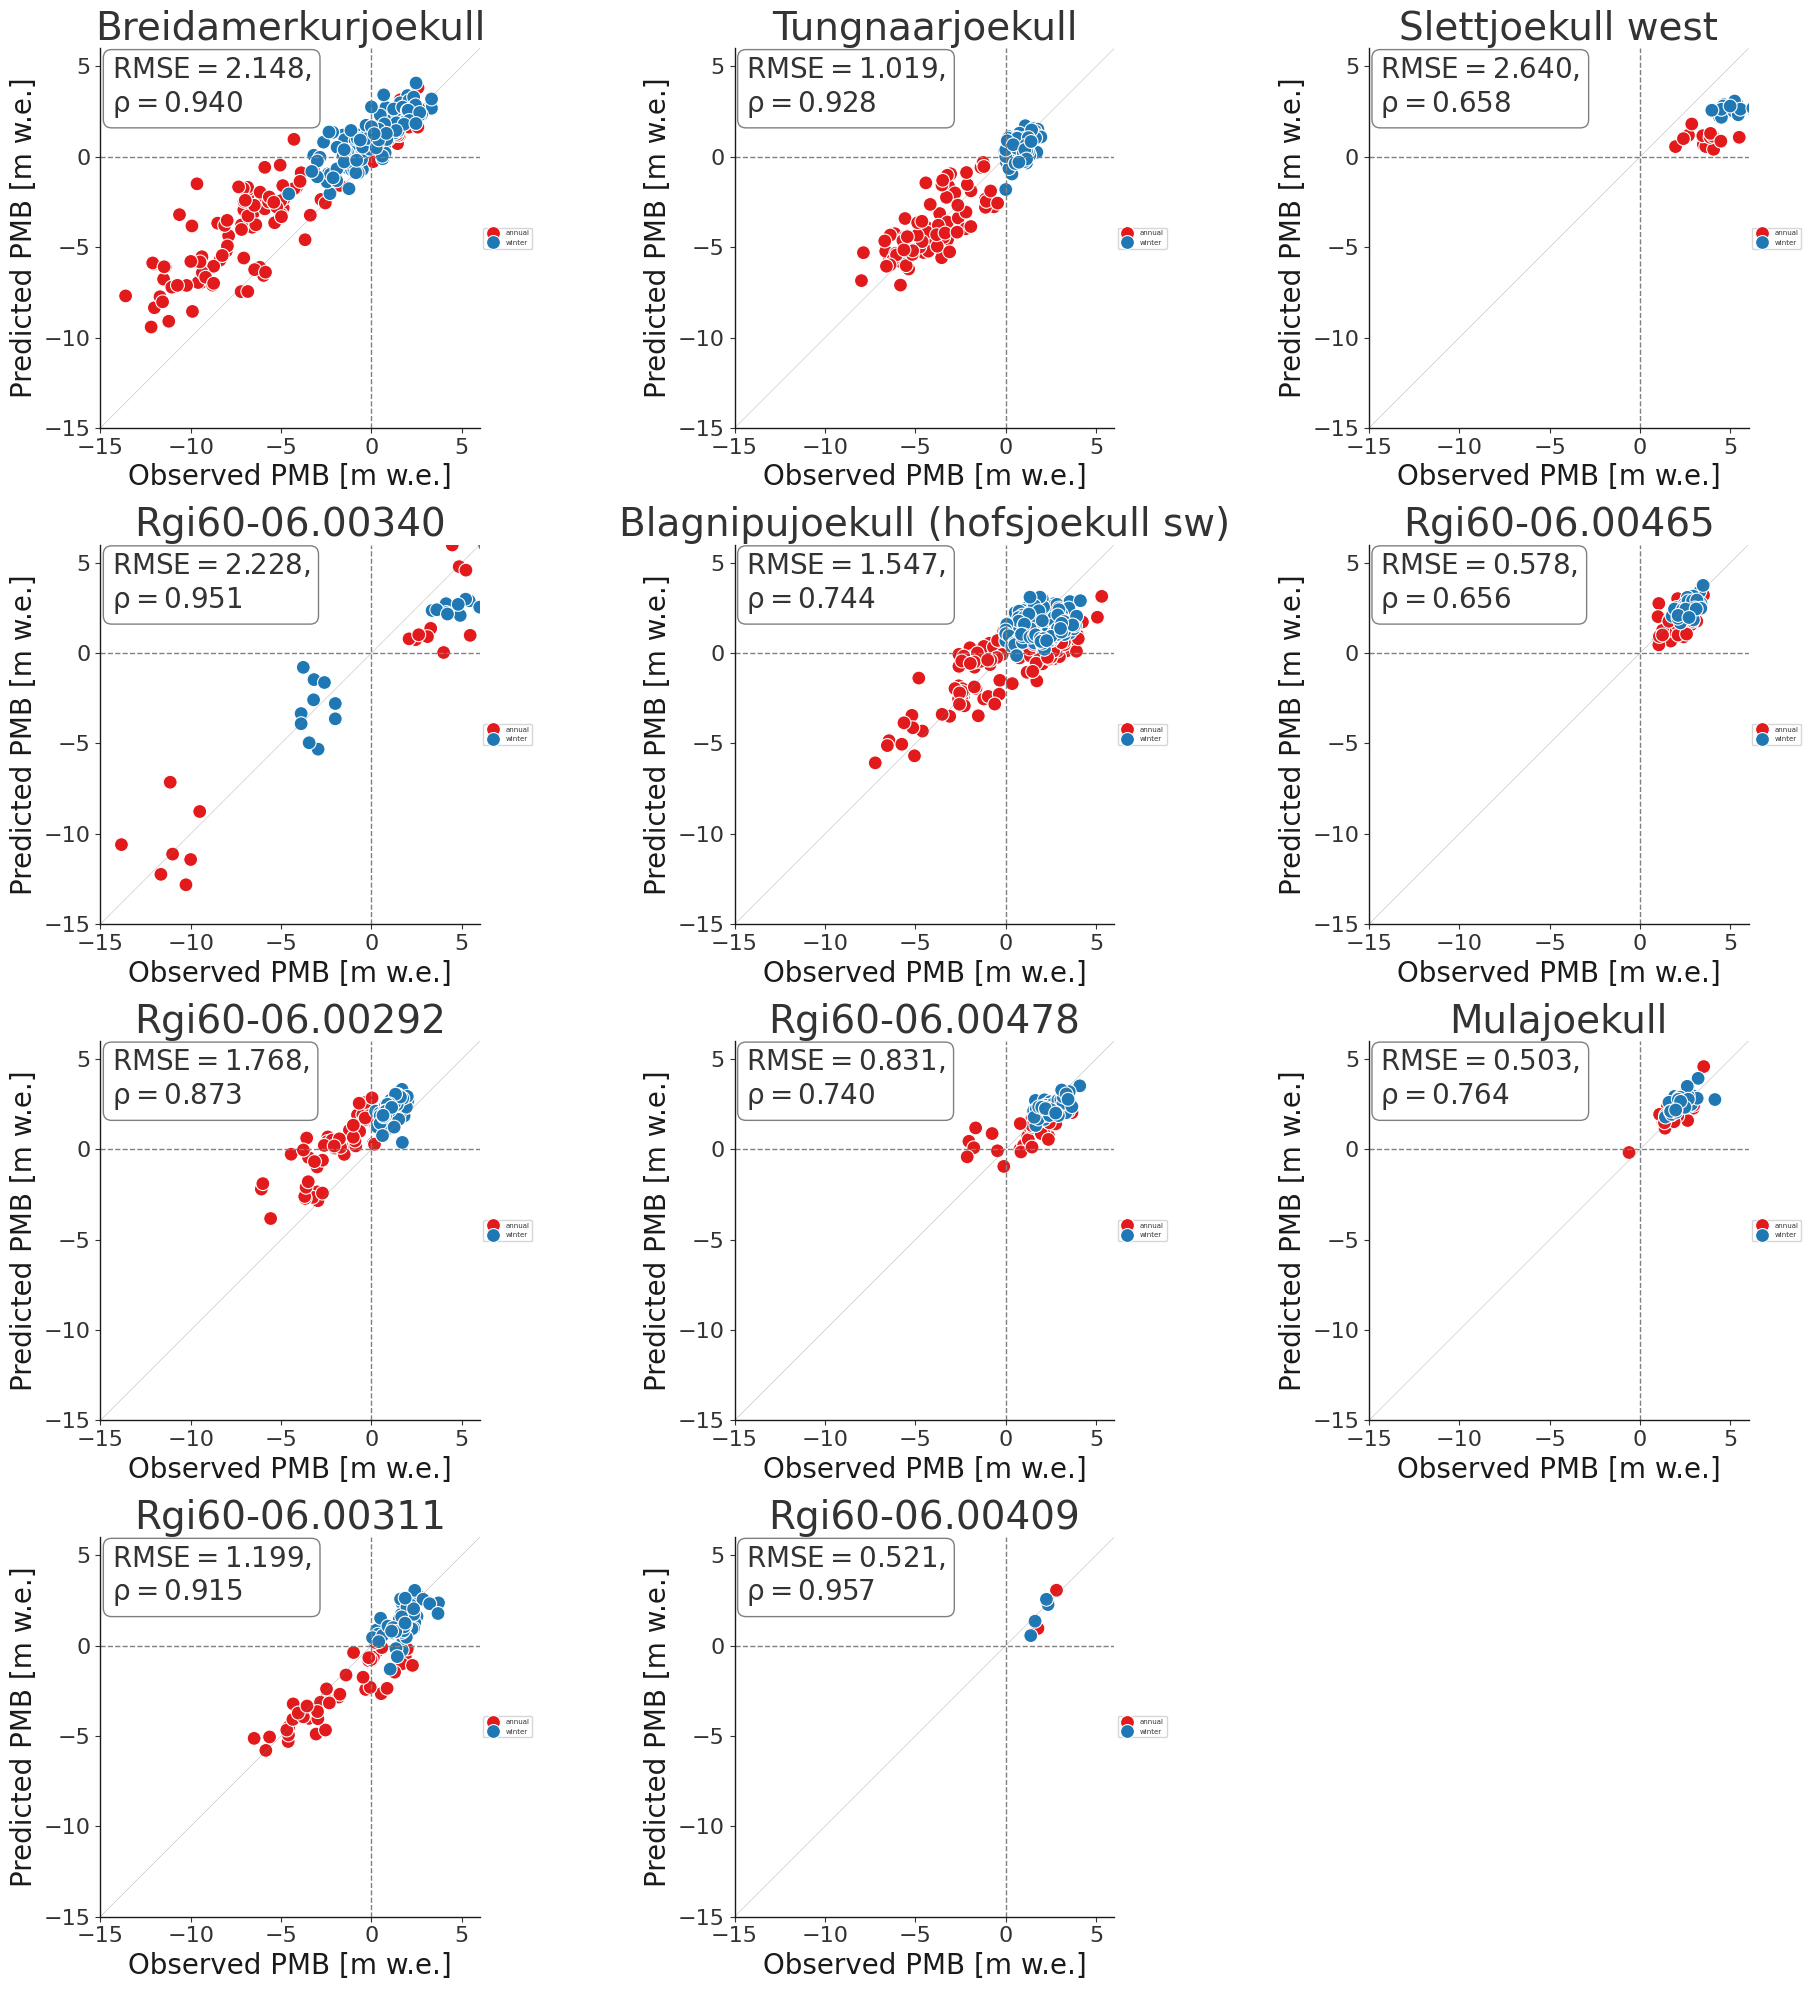

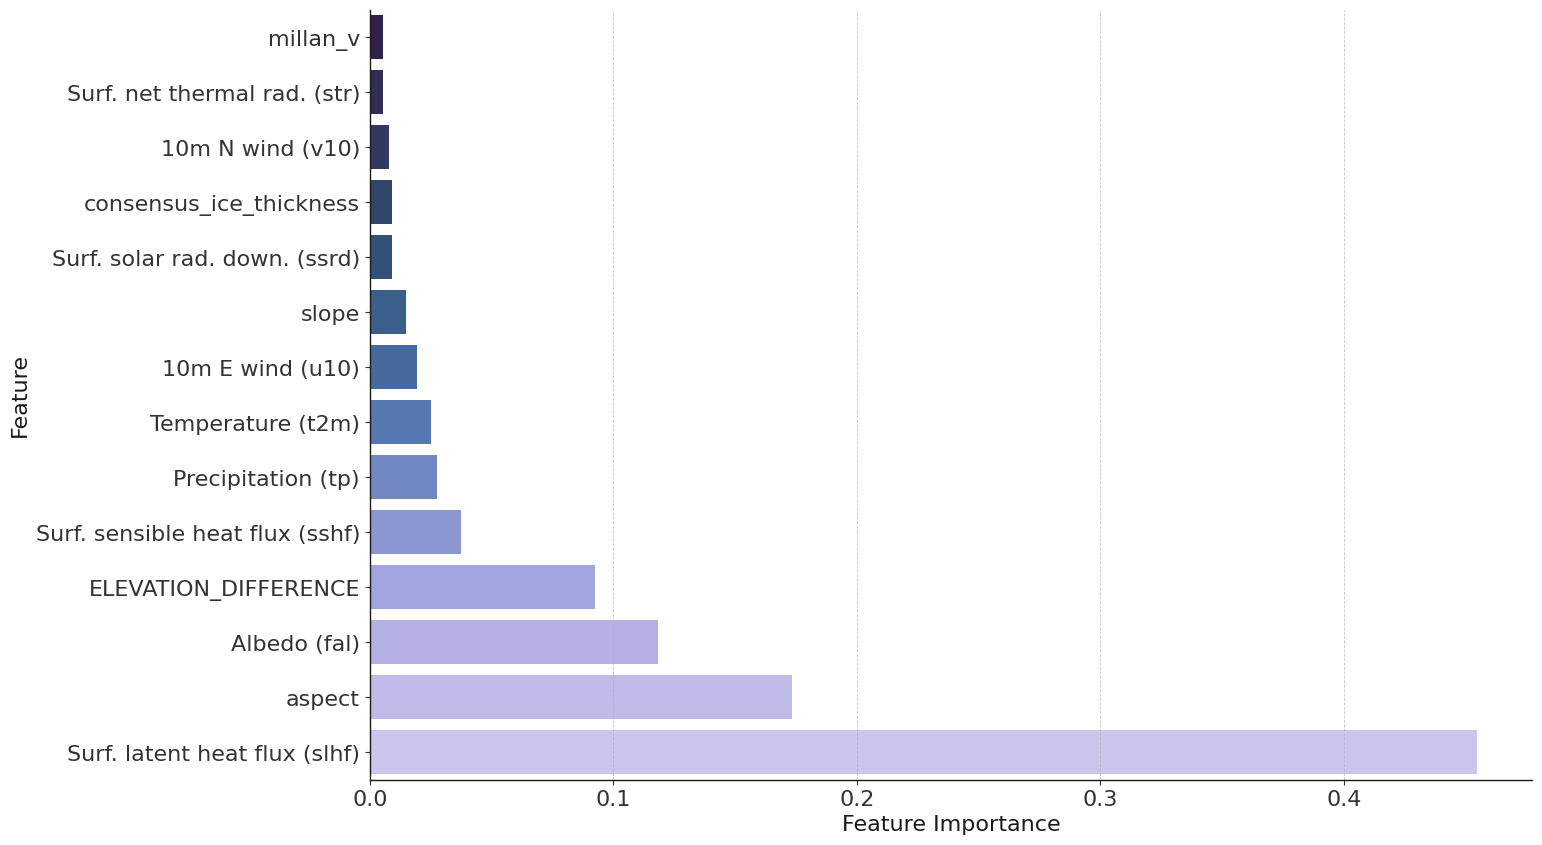

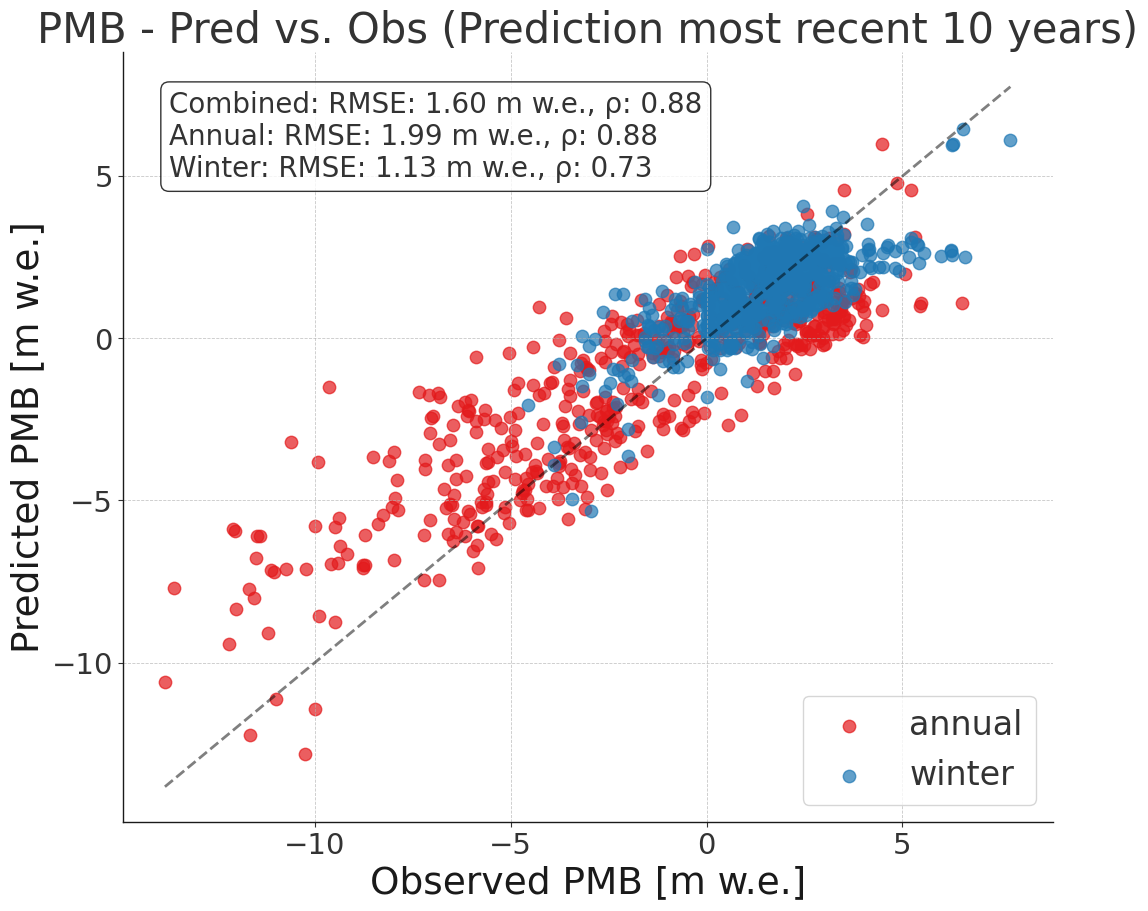

In [24]:
# Optimal Parameters for train CH
custom_params = {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500}

# Optimal Parameters for train ICE
#custom_params = {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 800}



# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)

PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                custom_model, region_name='Regional 75% train set', include_summer = False)